In [3]:
from data import loader
import pdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl

In [4]:
mpl.rcParams['figure.dpi'] = 1000
d1 = loader.get_global_case_and_deaths_time_series_data()
continent_list = loader.get_available_and_supported_continents()  # In case you want to see continents supported to pass into the call above
# d = loader.get_united_states_case_and_death_time_series_data(county=True)  # True if you want State + County, and False if you want only State and not county level.
print(continent_list)

['Africa', 'Asia', 'Europe', 'NorthAmerica', 'SouthAmerica']


#### Helper functions

In [5]:
def plot_sim_scores(sim_matrix, terr_names, data_type, continent="Africa"):
    """
    Plot the similarity scores between given country
    and save them to "results/similarity scores/"
    """
    if len(terr_names) > 35:
        label_size = 5
    else:
        label_size = 7

    plt.imshow(sim_matrix, vmin=0, vmax=1)
    plt.colorbar()

    ax = plt.gca()

    ax.set_xticks([i for i in range(len(terr_names))])
    # ax.set_xticklabels(terr_names, Rotation=90)
    ax.set_xticklabels(terr_names)
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    ax.set_yticks([i for i in range(len(terr_names))])
    ax.set_yticklabels(terr_names)
    ax.tick_params(axis='both', which='major', labelsize=label_size)
    
    if continent not in continent_list:
        plt.title(data_type + " cosine similarity for " + continent)
        plt.savefig("results/cos_similarity/countries/" + data_type + "_" + continent + ".png", transparent=False, facecolor='white')
    else:
        plt.title(data_type + " cosine similarity near " + terr_names[0])
        plt.savefig("results/cos_similarity/continents/" + continent + "/" + data_type + "_" + terr_names[0] + ".pdf", transparent=False, facecolor='white')
    plt.clf()

In [6]:
def compute_cos_scores_with_neighbors(continent):
    
    d2 = loader.get_continent_specific_case_and_deaths_time_series_data(continent=continent)

    # Get countries and territories names in the continent
    with open("data/territory_names/" + continent + "_countries.txt", "r") as f:
        country_names = [line.rstrip() for line in f]

    neighbors = pd.read_csv("data/neighbor_map/neighbors_world.csv")

    data_names = ["Case Count", "Death Count"]

    # For each country, generate the plot in the form of country - neighbors - casecount 0
    for df_idx, df in enumerate(d2):
        total_days = np.array(["Day" in x for x in df.columns]).sum()
        columns = ["Day " + str(day) for day in range(total_days)]
        for base_country in df["Admin0"]:
            # Create a matrix to store processed data [country + neighbors, columns]
            if type(neighbors.loc[neighbors["Country or territory"]==base_country]["neighbor list"].tolist()[0]) is str:
                list_of_neighbors = neighbors.loc[neighbors["Country or territory"]==base_country]["neighbor list"].tolist()[0].split(",")
            else:
                continue
            list_of_neighbors.insert(0, base_country)
            # Remove the neighbors not in the list and leading white space
            actual_list = []
            for idx in range(len(list_of_neighbors)):
                list_of_neighbors[idx] = list_of_neighbors[idx].lstrip()
                if list_of_neighbors[idx] in country_names:
                    actual_list.append(list_of_neighbors[idx])
            list_of_neighbors = actual_list

            processed_count = np.zeros([len(list_of_neighbors) + 1, len(columns)])
            for ctry_idx, country in enumerate(list_of_neighbors):
                for idx, col in enumerate(columns):
                    processed_count[ctry_idx, idx] = df[df["Admin0"]==country][col].values

            sim_matrix = np.zeros([len(list_of_neighbors), len(list_of_neighbors)])
            for i in range(len(list_of_neighbors)):
                for j in range(len(list_of_neighbors)):
                    sim_matrix[i, j] = processed_count[i, :].dot(processed_count[j, :])/ (np.linalg.norm(processed_count[i, :]) * np.linalg.norm(processed_count[j, :]))
            plot_sim_scores(sim_matrix, list_of_neighbors, data_names[df_idx], continent)

In [7]:
def compute_cos_scores_by_bucket(bucket_length):
    
    d1 = loader.get_global_case_and_deaths_time_series_data()
    data_names = ["Case Count", "Death Count"]
    all_sim = []
    # For each country, generate the plot in the form of country - neighbors - casecount 0
    for df_idx, df in enumerate(d1):
        # Begin with 3-22-20 instead of 1-22-20
        total_days = np.array(["Day" in x for x in df.columns]).sum()
        columns = ["Day " + str(day) for day in range(60, total_days)]
        
        columns_bucket = ["Bucket " + str(bucket) for bucket in range(int((total_days-60)/bucket_length) + 2)]
        groups = []
        for bucket in range(len(columns_bucket)):
            groups.append(["Day " + str(day) for day in range(bucket * bucket_length, (bucket + 1) * bucket_length)])
        
        # Compute the bucket values
        for bucket_idx, group in enumerate(groups):
            df[columns_bucket[bucket_idx]] = df[group].sum(axis=1)
        
        # For each country, create a corresponding time series vector
        buckets = df[columns_bucket].to_numpy() # num_countries * num_buckets
        country_list = df["Admin0"].to_list()

        cosine_sims = {}
        
        # Compute the cosine similarities for each country
        for country_idx, country in enumerate(country_list):
            country_cos_sim = []
            for target_country_idx, target_country in enumerate(country_list):
                country_cos_sim.append(buckets[country_idx].dot(buckets[target_country_idx]) / (np.linalg.norm(buckets[country_idx]) * np.linalg.norm(buckets[target_country_idx])))
            cosine_sims[country] = country_cos_sim
        all_sim.append(pd.DataFrame(cosine_sims, columns=country_list))
    return all_sim
print(compute_cos_scores_by_bucket(7))

<ipython-input-7-f72971223fac>:31: RuntimeWarning: invalid value encountered in double_scalars
  country_cos_sim.append(buckets[country_idx].dot(buckets[target_country_idx]) / (np.linalg.norm(buckets[country_idx]) * np.linalg.norm(buckets[target_country_idx])))


[     Afghanistan   Albania   Algeria   Andorra    Angola  Antigua and Barbuda  \
0       1.000000  0.131348  0.532904  0.119303  0.251529             0.065798   
1       0.131348  1.000000  0.569240  0.675114  0.570572             0.756202   
2       0.532904  0.569240  1.000000  0.456111  0.484007             0.331532   
3       0.119303  0.675114  0.456111  1.000000  0.753378             0.567655   
4       0.251529  0.570572  0.484007  0.753378  1.000000             0.672175   
..           ...       ...       ...       ...       ...                  ...   
191     0.223821  0.712522  0.550146  0.873815  0.856637             0.653830   
192     0.144714  0.703902  0.457022  0.909343  0.879698             0.652821   
193     0.033991  0.090095  0.089340  0.090956  0.083820             0.062063   
194     0.415182  0.535231  0.657854  0.249827  0.486527             0.573445   
195     0.175464  0.846552  0.617783  0.889978  0.775166             0.714070   

     Argentina   Armenia  

In [8]:
data_names = ["Case Count", "Death Count"]
def compute_cosine_sim_within_country(bucket_length, country_name):
    """
    country name has to be within the JHU dataset
    """
    # Get corresponding country's data
    d1 = loader.get_country_data_by_province(country_name)

    all_sims = []
    # For each region, generate the plot in the form of country - neighbors - casecount 0
    for df_idx, df in enumerate(d1):
        # Begin with 3-22-20 instead of 1-22-20
        total_days = np.array(["Day" in x for x in df.columns]).sum()
        columns = ["Day " + str(day) for day in range(60, total_days)]
        
        columns_bucket = ["Bucket " + str(bucket) for bucket in range(int((total_days-60)/bucket_length) + 2)]
        groups = []
        for bucket in range(len(columns_bucket)):
            groups.append(["Day " + str(day) for day in range(bucket * bucket_length, (bucket + 1) * bucket_length)])
        
        # Compute the bucket values
        for bucket_idx, group in enumerate(groups):
            df[columns_bucket[bucket_idx]] = df[group].sum(axis=1)
        
        # For each country, create a corresponding time series vector
        buckets = df[columns_bucket].to_numpy() # num_countries * num_buckets
        province_list = df["Admin1"].to_list()
        while "Unknown" in province_list:
            province_list.remove("Unknown")

        cosine_sims = {}
        
        # Compute the cosine similarities for each province
        for province_idx, province in enumerate(province_list):
            country_cos_sim = []
            for target_country_idx, target_country in enumerate(province_list):
                country_cos_sim.append(buckets[province_idx].dot(buckets[target_country_idx]) / (np.linalg.norm(buckets[province_idx]) * np.linalg.norm(buckets[target_country_idx])))
            cosine_sims[province] = country_cos_sim
        all_sims.append(pd.DataFrame(cosine_sims, columns=province_list))
    return all_sims, province_list

['Australian Capital Territory', 'New South Wales', 'Northern Territory', 'Queensland', 'South Australia', 'Tasmania', 'Victoria', 'Western Australia']


FileNotFoundError: [Errno 2] No such file or directory: 'results/similarity scores/countries/Case Count_Australia.png'

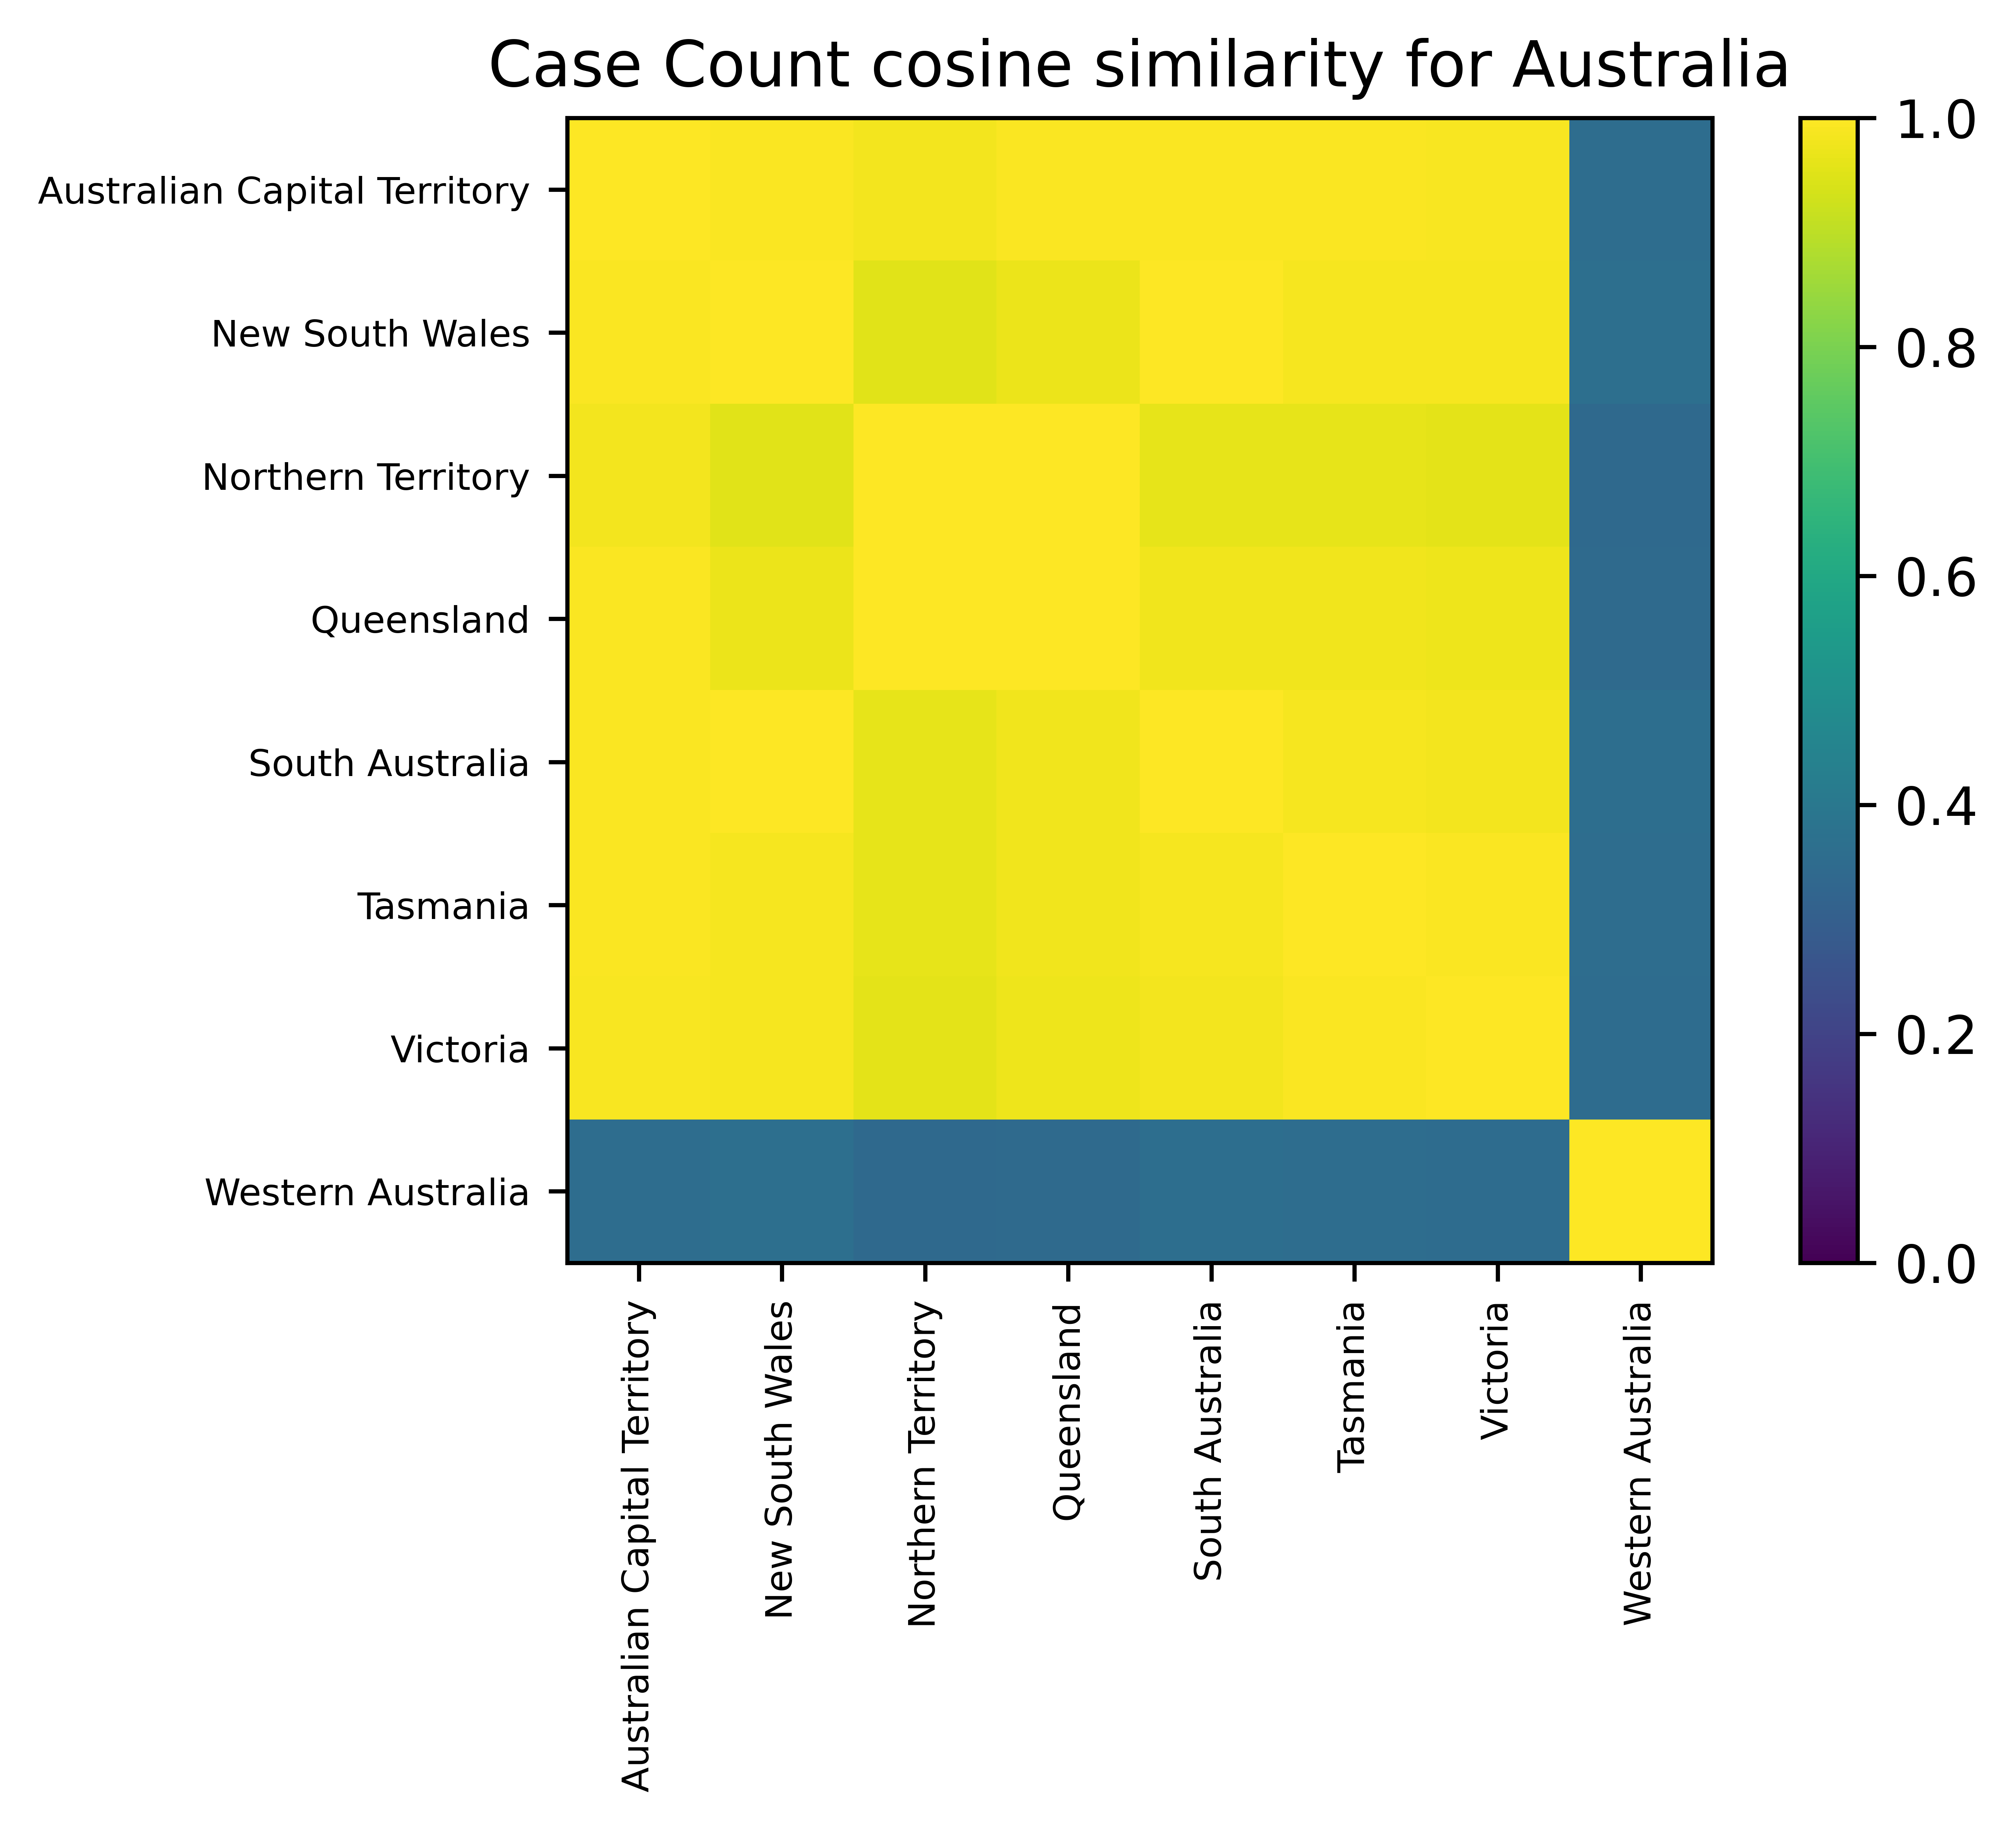

In [9]:
# Compute and plot
# interested_countries = ["Germany", "Italy", "Peru", "Japan"]
interested_countries = ["Australia", "Belgium", "China", "Denmark", "Malaysia", "Pakistan"]
for country_name in interested_countries:
    all_sims, province_list = compute_cosine_sim_within_country(7, country_name)
    print(province_list)
    for idx, data_name in enumerate(data_names):
        plot_sim_scores(all_sims[idx], province_list, data_name, continent=country_name)

In [11]:
def plot_sim_scores_for_paper(sim_matrix, terr_names, data_type, continent="Africa"):
    """
    Plot the similarity scores between given country
    and save them to "results/similarity scores/"
    Different from the scratch one, this one does not have title for figs
    """
    if len(terr_names) > 35:
        label_size = 5
    else:
        label_size = 7

    plt.imshow(sim_matrix, vmin=0, vmax=1)
    plt.colorbar()

    ax = plt.gca()

    ax.set_xticks([i for i in range(len(terr_names))])
    # ax.set_xticklabels(terr_names, Rotation=90)
    ax.set_xticklabels(terr_names)
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    ax.set_yticks([i for i in range(len(terr_names))])
    ax.set_yticklabels(terr_names)
    ax.tick_params(axis='both', which='major', labelsize=label_size)
    
    if continent not in continent_list:
        plt.savefig("results/paper result/similarity scores/countries/" + data_type + "_" + continent + ".png", transparent=False, facecolor='white')
    else:
        plt.savefig("results/paper result/similarity scores/" + data_type + "_" + terr_names[0] + ".pdf", transparent=False, facecolor='white')
    plt.clf()

In [17]:
target_countries = ["Ethiopia", "Chad", "Poland", "Germany", "Peru"]
def compute_cos_scores_with_neighbors(continent, bucket_length):
    
    d2 = loader.get_continent_specific_case_and_deaths_time_series_data(continent=continent)

    # Get countries and territories names in the continent
    with open("data/territory_names/" + continent + "_countries.txt", "r") as f:
        country_names = [line.rstrip() for line in f]

    neighbors = pd.read_csv("data/neighbor_map/neighbors_world.csv")

    data_names = ["Case Count", "Death Count"]

    # For each country, generate the plot in the form of country - neighbors - casecount 0
    for df_idx, df in enumerate(d2):
        total_days = np.array(["Day" in x for x in df.columns]).sum()
        for base_country in df["Admin0"]:
            # Create a matrix to store processed data [country + neighbors, columns]
            if type(neighbors.loc[neighbors["Country or territory"]==base_country]["neighbor list"].tolist()[0]) is str:
                list_of_neighbors = neighbors.loc[neighbors["Country or territory"]==base_country]["neighbor list"].tolist()[0].split(",")
            else:
                continue
            list_of_neighbors.insert(0, base_country)
            # Remove the neighbors not in the list and leading white space
            actual_list = []
            for idx in range(len(list_of_neighbors)):
                list_of_neighbors[idx] = list_of_neighbors[idx].lstrip()
                if list_of_neighbors[idx] in country_names:
                    actual_list.append(list_of_neighbors[idx])
            list_of_neighbors = actual_list

            columns_bucket = ["Bucket " + str(bucket) for bucket in range(int((total_days-60)/bucket_length) + 2)]
            groups = []
            for bucket in range(len(columns_bucket)):
                groups.append(["Day " + str(day) for day in range(bucket * bucket_length, (bucket + 1) * bucket_length)])
            
            # Compute the bucket values
            for bucket_idx, group in enumerate(groups):
                df[columns_bucket[bucket_idx]] = df[group].sum(axis=1)
            
            # For each country, create a corresponding time series vector
            buckets = df[columns_bucket].to_numpy() # num_countries * num_buckets
            country_list = list_of_neighbors

            cosine_sims = np.zeros([len(country_list), len(country_list)])
        
            # Compute the cosine similarities for each country
            for country_idx, _ in enumerate(country_list):
                for target_country_idx, _ in enumerate(country_list):
                    cosine_sims[country_idx, target_country_idx] = buckets[country_idx].dot(buckets[target_country_idx]) / (np.linalg.norm(buckets[country_idx]) * np.linalg.norm(buckets[target_country_idx]))
            if base_country in target_countries:
                plot_sim_scores_for_paper(cosine_sims, country_list, data_names[df_idx], continent)
                cosine_sims = np.zeros([len(country_list), len(country_list)])

for continent in continent_list:
    if continent != "Asia":
        compute_cos_scores_with_neighbors(continent, 7)

<Figure size 6000x4000 with 0 Axes>